<div class="alert alert-info">
Привет, Юлия! Меня зовут Светлана Чих и я буду проверять твой проект. Моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе.

<div class="alert alert-success">
<b>👍 Успех:</b> Зелёным цветом отмечены удачные и элегантные решения, на которые можно опираться в будущих проектах.
</div>
<div class="alert alert-warning">
<b>🤔 Рекомендация:</b> Жёлтым цветом выделено то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас (однако это не обязательно).
</div>
<div class="alert alert-danger">
<b>😔 Необходимо исправить:</b> Красным цветом выделены комментарии, без исправления которых, я не смогу принять проект :(
</div>
<div class="alert alert-info">
<b>👂 Совет:</b> Какие-то дополнительные материалы
</div>
Давай работать над проектом в диалоге: если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом.
Мне будет легче отследить изменения, если ты выделишь свои комментарии:
<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Например, вот так.</div>
Пожалуйста, не перемещай, не изменяй и не удаляй мои комментарии. Всё это поможет выполнить повторную проверку твоего проекта быстрее.
 </div>

# Банки — Анализ оттока клиентов
## Цель - выявить сегменты клиентов банка, наиболее склонных к оттоку.

Нам необходимо выделить группы клиентов, наиболее склонных к оттоку для дальнейшей выбаботки маркетинговой службой специальных предложений, направленных на удержание клиентов.  
План работы:  
1) Предобработать данные, выявить проблемы и закономерности  
2) Построить модель классификации, обучить ее и получить высокое качество предсказаний оттока  
3) С помощью данных feature_importance выделить параметры, наболее сильно влияющие на отток.  
4) Построить сегменты, склонных уходить клиентов  
5) Сформулировать и проверить статистические гипотезы  
6) Сфорулировать выводы и предложения

<div class="alert alert-danger">
<b>😔 Необходимо исправить:</b> Должно быть описание задачи, цель проекта и план его выполнения
</div>

In [1]:
pip install -U imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [270]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"
import numpy as np

from scipy import stats as st
from xgboost import  XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn import set_config
from sklearn.utils import shuffle
from numpy.random import RandomState
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline as sk_Pipeline
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)

<a id='data_download'></a>
### 1. Загрузка данных и знакомство с ними

In [271]:
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F"
df = pd.read_csv(path)

In [272]:
df.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.000,Рыбинск,Ж,25,1,59214.820,2,0,1,75719.140,1
1,146556,861.000,Рыбинск,Ж,37,5,850594.330,3,1,0,86621.770,0
2,120722,892.000,Рыбинск,Ж,30,0,NaN,1,1,1,107683.340,0
3,225363,866.000,Ярославль,Ж,51,5,1524746.260,2,0,1,174423.530,1
4,157978,730.000,Ярославль,М,34,5,174.000,1,1,0,67353.160,1


<div class="alert alert-success">
<b>👍 Успех:</b> Датасет загружен и просмотрен
</div>

<a id='data_preprocessing'></a>
### 2. Предобработка данных

In [273]:
# приведем столбцы к нижнему регистру:
df.columns = df.columns.str.lower()

In [274]:
# переименуем столбец userid 
df = df.rename(columns={'userid' : 'user_id'})

In [275]:
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.000,Рыбинск,Ж,25,1,59214.820,2,0,1,75719.140,1
1,146556,861.000,Рыбинск,Ж,37,5,850594.330,3,1,0,86621.770,0
2,120722,892.000,Рыбинск,Ж,30,0,NaN,1,1,1,107683.340,0
3,225363,866.000,Ярославль,Ж,51,5,1524746.260,2,0,1,174423.530,1
4,157978,730.000,Ярославль,М,34,5,174.000,1,1,0,67353.160,1


In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  int64  
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


In [277]:
df.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,10000.000,10000.000,10000.000,10000.000,7705.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,171814.713,848.699,42.837,2.628,827794.307,1.874,0.680,0.523,147866.886,0.182
std,33708.238,65.449,12.129,1.981,1980614.147,0.800,0.466,0.499,139388.511,0.386
min,94561.000,642.000,18.000,0.000,0.000,0.000,0.000,0.000,2546.300,0.000
25%,142810.250,802.000,34.000,0.000,295554.160,1.000,0.000,0.000,75251.900,0.000
50%,172728.000,853.000,40.000,3.000,524272.200,2.000,1.000,1.000,119658.105,0.000
75%,201261.750,900.000,51.000,4.000,980705.850,2.000,1.000,1.000,174500.542,0.000
max,229145.000,1000.000,86.000,9.000,119113552.010,5.000,1.000,1.000,1395064.450,1.000


In [278]:
# Проверим пропуски
df.isna().sum()

user_id             0
score               0
city                0
gender              0
age                 0
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

In [279]:
# проверим на дубликаты
df.duplicated().sum()

1

In [280]:
df[df.duplicated()]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
9457,141945,929.000,Ярославль,М,33,0,NaN,1,1,0,381868.890,0


In [281]:
#удалим дубликат
df = df.drop_duplicates()

#### столбец user_id

In [282]:
df.user_id.duplicated().sum()

72

In [283]:
ids = df['user_id']

In [284]:
df[ids.isin(ids[ids.duplicated()])].sort_values("user_id")

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
7694,116540,887.000,Ярославль,Ж,38,0,NaN,1,0,1,119247.610,0
1893,116540,883.000,Ярославль,Ж,55,1,362756.490,3,0,1,175920.480,1
4866,117943,855.000,Рыбинск,Ж,32,6,1036832.930,4,1,1,107792.710,1
7542,117943,880.000,Ярославль,Ж,40,0,NaN,1,1,0,137718.930,0
5863,120258,908.000,Рыбинск,Ж,38,4,2213581.630,2,0,1,160327.770,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2597,226719,990.000,Ярославль,М,37,4,14648692.140,2,0,0,934412.610,1
8205,227795,840.000,Рыбинск,М,34,2,350768.030,1,1,0,102036.140,1
8497,227795,839.000,Рыбинск,М,34,2,326593.140,2,1,0,103314.920,0
6457,228075,839.000,Ярославль,М,39,5,507199.850,3,0,1,85195.800,0


Существуют дубликаты user_id, их очень мало - 72 строки, похоже, что имеет место ошибка сбора данных, но на качество данных для наших целей это не влияет: user_id как таковой нам не нужен при анализе, можем эту проблему игнорировать.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

#### столбец score

In [285]:
fig = px.histogram(df, x='score')
fig.show()

Распределние баллов нормально, в целом нормальное, с выделяющимися пиками на уровне 875-925 баллов

#### стоблец city

In [286]:
df.city.value_counts().sort_values(ascending=False)

Ярославль    5905
Рыбинск      2663
Ростов       1431
Name: city, dtype: int64

Всего в данных представлено 3 города: Ярославль, Рыбинск, Ростов, больше всего клиентов из Ярославля

#### столбец gender

In [287]:
df.gender.value_counts()

М    5007
Ж    4992
Name: gender, dtype: int64

Клиенты разделяются на 2 пола примерно поровну

In [288]:
# Для целей дальнейшей обработки, заменим М - 1 Ж 0:
df.gender = df.gender.map({'М':1, 'Ж':0})

In [289]:
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.000,Рыбинск,0,25,1,59214.820,2,0,1,75719.140,1
1,146556,861.000,Рыбинск,0,37,5,850594.330,3,1,0,86621.770,0
2,120722,892.000,Рыбинск,0,30,0,NaN,1,1,1,107683.340,0
3,225363,866.000,Ярославль,0,51,5,1524746.260,2,0,1,174423.530,1
4,157978,730.000,Ярославль,1,34,5,174.000,1,1,0,67353.160,1


#### столбец age

In [290]:
fig = px.histogram(df, x='age', title='Распределение клиентов банка по возрасту')
fig.show()

<div class="alert alert-danger">
<b>😔 Необходимо исправить:</b> Визуализация не отображается во всем разделе
</div>

Среди клиентов прсуствуют люди от 18 до 86 лет, возрастная пирамида сдвинута влево, больше всего молодых трудоспособных людей (30-45 лет)

#### столбец equity

In [291]:
df.equity.value_counts()

0    2591
5    1918
4    1850
3    1543
2    1052
1     774
6     161
7      80
8      17
9      13
Name: equity, dtype: int64

In [292]:
fig = px.histogram(df, x='equity', title='Распределение клиентов по наличию объектов собственности')
fig.show()

Больше всего клиентов вообще не обладают никакой собственностью, второе и третье места в рейтинге у "обеспеченных" клиентов с 5 и 4 объектами недвижимости

#### столбец balance

In [293]:
(df.balance.mean(), df.balance.median())

(827794.3065100583, 524272.2)

In [294]:
df.balance.isna().sum()

2294

In [295]:
df[df.balance.isna()]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,120722,892.000,Рыбинск,0,30,0,NaN,1,1,1,107683.340,0
9,133130,906.000,Ярославль,0,67,0,NaN,1,0,1,238055.530,0
10,148929,927.000,Ростов,1,52,0,NaN,1,1,1,196820.070,0
11,172184,921.000,Ростов,1,41,0,NaN,1,1,1,217469.480,0
19,127034,922.000,Рыбинск,0,53,0,NaN,1,0,0,147094.820,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9976,208085,876.000,Ростов,1,38,0,NaN,1,0,0,171763.690,0
9984,125941,729.000,Ярославль,0,42,0,NaN,1,1,1,687538.700,0
9993,219924,884.000,Рыбинск,0,36,0,NaN,1,1,1,169844.880,0
9996,139170,894.000,Ярославль,1,46,0,NaN,1,1,0,196898.290,0


In [296]:
# Отсутсвие данных по балансу - скорее всего ошибка сбора/хранения данных, 
# в целях исследования заменим пропуски нулями:
df.balance = df.balance.fillna(0)

In [297]:
df.balance.isna().sum()

0

#### столбец products

In [298]:
df.products.value_counts()

2    5108
1    3340
3    1046
4     474
5      30
0       1
Name: products, dtype: int64

Отсутсвие продуктов - это скорее всего ошибка, удалим эту строку:

In [299]:
df = df.query('products > 0')

In [300]:
fig = px.histogram(df, x='products')
fig.show()

Больше всего клиентов с 2 банковскими продуктами

#### столбец credit_card

In [301]:
df.credit_card.value_counts()

1    6803
0    3195
Name: credit_card, dtype: int64

Кредитной картой пользуется почти 70% клиентов

#### столбец last_activity

In [302]:
df.last_activity.value_counts()

1    5235
0    4763
Name: last_activity, dtype: int64

Клиенты разделились примерно поровну на активных и неактивных пользователей

#### столбец est_salary

In [303]:
fig = px.histogram(df, x='est_salary')
fig.show()

In [304]:
fig = px.histogram(df, x='est_salary')
fig.update_layout(xaxis_range=[0, 200000])
fig.show()

Самая часто встречающаяся зарплата клиентов банка - около 100 тыс рублей 

####   Столбец churn

In [305]:
df.churn.value_counts()

0    8177
1    1821
Name: churn, dtype: int64

Видим, что данные несбалансированы: только 18% клиентов помечены, как ушедшие

Посмотрим корреляцию признаков:

In [306]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,user_id,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
user_id,1.000000,0.010039,0.030613,0.018040,0.004495,0.004429,-0.005948,0.005632,-0.031202,-0.000283,-0.012292
score,0.010039,1.000000,0.012748,-0.012590,0.064277,0.144463,-0.004444,-0.094597,-0.030879,0.163879,0.105868
gender,0.030613,0.012748,1.000000,-0.224822,-0.021463,0.032502,-0.023512,0.126147,-0.013093,0.082276,0.140999
age,0.018040,-0.012590,-0.224822,1.000000,0.032789,0.070970,0.032446,-0.131030,-0.003939,-0.042934,-0.056509
equity,0.004495,0.064277,-0.021463,0.032789,1.000000,0.252371,0.430285,-0.167425,-0.002090,-0.171781,0.270658
balance,0.004429,0.144463,0.032502,0.070970,0.252371,1.000000,0.155470,-0.083618,0.015892,0.159240,0.129848
products,-0.005948,-0.004444,-0.023512,0.032446,0.430285,0.155470,1.000000,-0.256778,0.039728,-0.119822,0.297725
credit_card,0.005632,-0.094597,0.126147,-0.131030,-0.167425,-0.083618,-0.256778,1.000000,-0.033534,0.035323,-0.131197
last_activity,-0.031202,-0.030879,-0.013093,-0.003939,-0.002090,0.015892,0.039728,-0.033534,1.000000,0.003123,0.169421
est_salary,-0.000283,0.163879,0.082276,-0.042934,-0.171781,0.159240,-0.119822,0.035323,0.003123,1.000000,0.001394


Удивительно, но однозначно линейно зависимых столбцов нет, отток нельзя объяснить каким-то одним признаком

<a id='data_preparation'></a>
### 3. Подготовка признаков

<div class="alert alert-danger">
<b>😔 Необходимо исправить:</b> Круто, а зачем здесь моделька и какую задачу она решает? Очень хочется подробностей, давь сюда описание происходящего
</div>

Модель классификации высокого качества поможет нам выделить параметры, в наибольшей степени влияющие на отток клиентов.  
В качестве метрики качества выберем  Roc-auc-score - он в меньшей мере зависит от дисбаланса целевой переменной  
После обучения модели построим карту feature importance, выберем признаки, влиящие на отток.

In [307]:
df.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

In [308]:
# Удалим столбец user_id

In [309]:
df = df.drop(columns='user_id', axis=0)

In [310]:
df.columns

Index(['score', 'city', 'gender', 'age', 'equity', 'balance', 'products',
       'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

<a id='modeling'></a>
### 4. Построение модели

In [313]:
#Разделим датасет на обучающую и тестовую выборки:
features = df.drop(columns='churn', axis=0)
target = df.churn
features_train, features_test, target_train, target_test \
    = train_test_split(features, target, train_size=0.75, random_state = 123, shuffle=target) 

In [314]:
(features_train.shape, target_train.shape)

((7498, 10), (7498,))

In [315]:
(features_test.shape, target_test.shape)

((2500, 10), (2500,))

In [316]:
# Создадим pipeline:
state = RandomState(123)

In [317]:
classifiers = [
  LogisticRegression(random_state=state),
  RandomForestClassifier(random_state=state),
  XGBClassifier(random_state=state),
  AdaBoostClassifier()
]

In [318]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)

In [319]:
class_prarms = [
    { 'class__solver' : ['lbfgs', 'liblinear'],'class__penalty' :['l1','l2','none'], 'class__C': np.arange(0.5,1.5,0.25), 'class__fit_intercept' : [True, False] },
    {'class__max_features': ['auto','log2','sqrt', 'None'],'class__criterion' : ['gini', 'log_loss', 'entropy'], 'class__n_estimators' : range(10,1000,10), 'class__max_depth' : range(1,50), 'class__min_samples_split': range(1,10), 'class__min_samples_leaf': range(1,10)},
    {'class__eta': np.arange(0.01, 0.2, 0.01), 'class__max_depth': range(3,20), 'class__gamma' : np.arange(0,1,0.001),'class__learning_rate': np.arange(0.01, 1, 0.001), 'class__booster':['gbtree','gblinear'], 'class__n_estimators': range(10,1000,5)},
    {'class__n_estimators' : range(10,1000,10), 'class__learning_rate' : np.arange(0.1, 1, 0.01),'class__algorithm' : ['SAMME','SAMME.R'] }
]
cv = KFold(n_splits=10, shuffle=True, random_state=state)

In [320]:
df.columns

Index(['score', 'city', 'gender', 'age', 'equity', 'balance', 'products',
       'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

In [321]:
cat_col = ['city', 'gender', 'credit_card', 'last_activity']
m_col = ['score', 'balance', 'age','equity','products', 'est_salary']

In [322]:
t = [('cat', OneHotEncoder(), cat_col), ('num', StandardScaler(), m_col)]
col_transform = ColumnTransformer(transformers=t)

In [323]:
from scipy import rand


best_esimators = []
best_score = []
for i, classifier in enumerate(classifiers):
    steps = [
       ('prep',col_transform),
       ('smote', SMOTE(random_state=state)),
       ('selector', VarianceThreshold()),
       ('class', classifier)
    ]
    pipeline = Pipeline(steps)
    grid = RandomizedSearchCV(pipeline,class_prarms[i] , scoring=roc_auc_scorer, cv=cv, n_iter=10)
    grid.fit(features_train, target_train)
    print(classifier, grid.best_estimator_)
    best_esimators.append(grid.best_estimator_)
    best_score.append(grid.best_score_)
   

LogisticRegression(random_state=RandomState(MT19937) at 0x1506CC540) Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['city', 'gender',
                                                   'credit_card',
                                                   'last_activity']),
                                                 ('num', StandardScaler(),
                                                  ['score', 'balance', 'age',
                                                   'equity', 'products',
                                                   'est_salary'])])),
                ('smote',
                 SMOTE(random_state=RandomState(MT19937) at 0x1506CCD40)),
                ('selector', VarianceThreshold()),
                ('class',
                 LogisticRegression(random_state=RandomState(MT19937) at 0x1506CCE40))])
RandomForestClassifier(random_state=RandomState(MT19937) at 0x15

In [356]:
best_score

[0.802830685182812, 0.8908061100122625, 0.8862188821456239, 0.8474859434359837]

In [358]:
best_esimators[1]

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['city', 'gender',
                                                   'credit_card',
                                                   'last_activity']),
                                                 ('num', StandardScaler(),
                                                  ['score', 'balance', 'age',
                                                   'equity', 'products',
                                                   'est_salary'])])),
                ('smote',
                 SMOTE(random_state=RandomState(MT19937) at 0x15066BD40)),
                ('selector', VarianceThreshold()),
                ('class',
                 RandomForestClassifier(max_depth=22, min_samples_split=9,
                                        n_estimators=580,
                                        random_state=RandomState(MT19937) at 0x150617840))])

In [359]:
features_train_enc = pd.get_dummies(features_train, drop_first=True)

In [362]:
model = best_esimators[1][3]
model.fit(features_train_enc, target_train)
print(model.feature_importances_)

[0.18257217 0.03593716 0.13050975 0.07308942 0.20404053 0.10477157
 0.03243032 0.07839489 0.12422849 0.01788246 0.01614324]


<a id='segmentation'></a>
### 5. Сегментирование

In [363]:
feat_importances = pd.Series(model.feature_importances_, index=features_train_enc.columns)

In [364]:
data = pd.Series(model.feature_importances_, index=features_train_enc.columns).to_frame()

In [365]:
fig = px.bar(data.sort_values(by=0), orientation='h')
fig.update_layout(
    title="Влияние параметров на предсказание",
    xaxis_title="параметр",
    yaxis_title="важность")
fig.update_layout(showlegend=False)
fig.show()

Видим, что наибольшим влиянием на вероятность ухода клиента обладают:  
* balance  
* score  
* age  
* est_salary  
* products


Разделим наш датасет по вышевыбранным признакам на группы приблизительно по  1000 человек, посмотрим, как распределятся отток в группах и составим сегменты уходящих клиентов.

In [366]:
# balance
balance = df[['balance', 'churn']]
balance=balance.query('balance>0')
balance['balance_grp'] = pd.qcut(balance['balance'],10)
balance.groupby('balance_grp', as_index=False).agg({'churn':'mean'})\
    .sort_values('churn', ascending=False)

,balance_grp,churn
9,"(1460158.524, 119113552.01]",0.488
8,"(1125664.98, 1460158.524]",0.345
7,"(853694.39, 1125664.98]",0.249
6,"(660340.838, 853694.39]",0.235
4,"(419685.14, 524295.33]",0.191
5,"(524295.33, 660340.838]",0.188
3,"(337335.706, 419685.14]",0.178
0,"(5.999, 159339.48]",0.165
2,"(256178.874, 337335.706]",0.160
1,"(159339.48, 256178.874]",0.149


In [367]:
#score
score = df[['score', 'churn']]
score['score_grp'] = pd.qcut(score['score'], 10)
score.groupby('score_grp', as_index=False).agg({'churn':'mean'})\
    .sort_values('churn', ascending=False)

,score_grp,churn
5,"(853.0, 873.0]",0.299
6,"(873.0, 892.0]",0.254
4,"(832.0, 853.0]",0.233
7,"(892.0, 908.0]",0.204
3,"(812.0, 832.0]",0.189
8,"(908.0, 928.0]",0.176
9,"(928.0, 1000.0]",0.164
2,"(791.0, 812.0]",0.151
1,"(765.0, 791.0]",0.107
0,"(641.999, 765.0]",0.046


In [368]:
#age
age = df[['age', 'churn']]
age['age_grp'] = pd.qcut(age['age'], 10)
age.groupby('age_grp', as_index=False).agg({'churn':'mean'})\
    .sort_values('churn', ascending=False)

,age_grp,churn
8,"(54.0, 61.0]",0.250
7,"(48.0, 54.0]",0.241
0,"(17.999, 29.0]",0.235
2,"(32.0, 35.0]",0.203
1,"(29.0, 32.0]",0.199
4,"(37.0, 40.0]",0.166
3,"(35.0, 37.0]",0.165
5,"(40.0, 44.0]",0.141
6,"(44.0, 48.0]",0.136
9,"(61.0, 86.0]",0.046


In [369]:
#est_salary
salary = df[['est_salary', 'churn']]
salary['salary'] = pd.qcut(salary['est_salary'], 10)
salary.groupby('salary', as_index=False).agg({'churn':'mean'})\
    .sort_values('churn', ascending=False)

,salary,churn
4,"(101310.838, 119658.105]",0.208
7,"(161594.864, 189203.126]",0.206
5,"(119658.105, 139355.704]",0.204
8,"(189203.126, 242142.643]",0.194
6,"(139355.704, 161594.864]",0.193
3,"(83922.086, 101310.838]",0.175
9,"(242142.643, 1395064.45]",0.174
2,"(66404.108, 83922.086]",0.168
1,"(45485.197, 66404.108]",0.161
0,"(2546.299, 45485.197]",0.138


In [370]:
df.groupby('products', as_index=False).\
    agg({'churn':['mean', 'count']})

products churn      
            mean count
0        1 0.070  3340
1        2 0.192  5108
2        3 0.285  1046
3        4 0.633   474
4        5 0.300    30

Сформируем сегменты "уходящих" клиентов  
1) По количеству продуктов и балансу
2) По возрасту и зарплате
3) По скорингу и количеству продуктов

In [371]:
balance_products = df.query('balance > 1125664.98 & products>=3')

In [372]:
balance_products.shape[0]

530

In [373]:
balance_products['churn'].mean().round(2)

0.58

В нашем сегменте 530 человек, средний отток - 58% - это очень много

Выделим сегмент по  возрасту и зарплате

In [374]:
df['age_grp'] = pd.qcut(df['age'], 10)
df['salary_grp'] = pd.qcut(df['est_salary'],10)

In [375]:
age_salary = df.pivot_table(
    index='age_grp', columns='salary_grp', values='churn', aggfunc='mean')


Text(50.72222222222221, 0.5, 'Возраст')

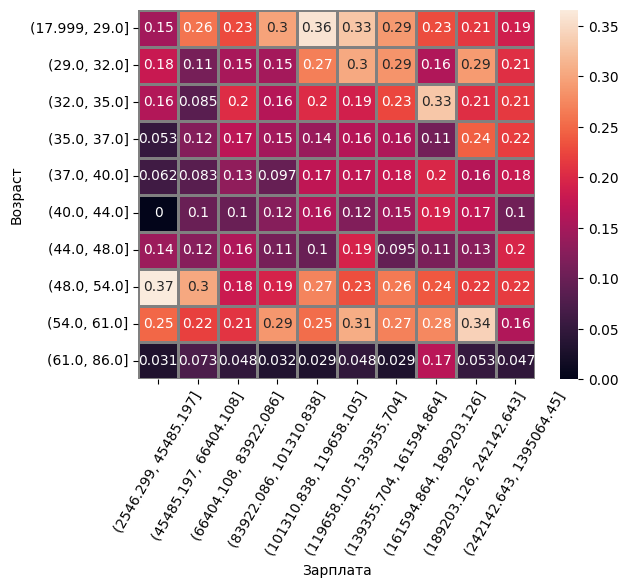

In [376]:
sns.heatmap(age_salary, annot=True, linewidths=1, linecolor='gray')
plt.xlabel('Зарплата') 
plt.xticks(rotation=60)

plt.ylabel('Возраст')

Очень высокий отток в возрастной группе  от  18 до 32 и зарплате от 83 до 140 тыс, посмотрим:

In [377]:
age_salary = df.query('age>=26 & age <=32 & est_salary >=83000 & est_salary <=140000')

In [378]:
age_salary.shape[0]

551

In [379]:
age_salary.churn.mean().round(2)

0.29

Во втором сегменте клиенты от 26 до 32 лет с зарплатой от 83 до 140 тыс рублей, в сегменте 551 человек, средний отток - 29%

Выделим сегмент по скоррингу и количеству продуктов

In [380]:
df['score_grp'] = pd.qcut(df['score'],10)
score_products = df.pivot_table(
    index='score_grp', columns='products', values='churn', aggfunc='mean')



Text(50.72222222222221, 0.5, 'Scorring')

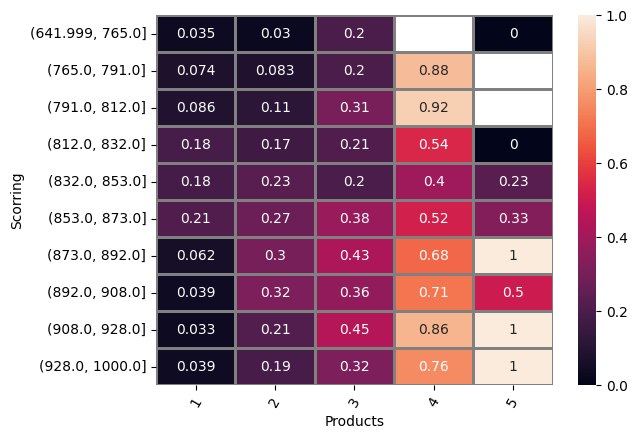

In [382]:
sns.heatmap(score_products, annot=True, linewidths=1, linecolor='gray')
plt.xlabel('Products') 
plt.xticks(rotation=60)

plt.ylabel('Scorring')

In [390]:
df.query('score >=873 & score <= 1000 & products >= 3').shape[0]

540

In [392]:
df.query('score >=873 & score <= 1000 & products >= 3')['churn'].mean().round(2)

0.55

В сегменте со скоррингом от 873 баллов и 3 продуктов отток - 55%, в сегменте 540 клиентво

Получили три примерно равных по численности сегмента клиентов, склонных к уходу:


**Баланс/Продукты**:  
- Имеют на балансе более `1 млн 125 тыс` руб  
- Владеют `более, чем 3` продуктами   


**Зарплата/Возраст**:  
- Возраст клиентов от `26 до 32 лет` 
- Зарплата от  `83 до 140 тыс рублей`

**Скорринг/Продукты**:  
- Скорринг от  `873 до 1000` 
- Владеют   `более, чем 3` продуктами   


<div class="alert alert-danger">
<b>😔 Необходимо исправить:</b> Какова численность этих сегментов? Предлагаю выделить еще несколько сегментов и посмотреть отток
</div>

<a id='statistics'></a>
### 6. Проверка гипотез

Сформулируем статистические гипотезы: Гипотеза о равенстве дохода 
HO: доход в первом и втором сегменте  не отличается  
H1: доход  в  первом и втором сегментах отличаются

In [394]:
first_segment = df.query('balance >= 1125000 and products >=3')
second_segment = df.query('age >=26  and age <= 32 and est_salary>=86000 and est_salary <=140000')
third_sgement = df.query('score >= 873 and score <=1000 and products==4')

In [395]:
alpha = 0.05
results = st.ttest_ind(first_segment['est_salary'], second_segment['est_salary'])
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, pvalue =', results.pvalue)
else:
    print('Не можем отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу, pvalue = 2.466330563720383e-25


Нет данных утвреждать, что доход в сегментах отличается

Гипотеза о различной активности  клиентов в 2 и 3 сегментах:  
HO: активность  клиентов в 2  и 3 сегментах  не отличается  
H1: активность  клиентов в 2  и 3 сегментах  отличается

In [396]:
alpha = 0.05
results = st.ttest_ind(second_segment['last_activity'], third_sgement['last_activity'])
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, pvalue =', results.pvalue)
else:
    print('Не можем отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу, pvalue = 0.010833866514110821


Есть основания предполагать, что активность клиентов во 2 и в 3 сегменте различна:

In [398]:
(second_segment.last_activity.mean().round(2), third_sgement.last_activity.mean().round(2))

(0.58, 0.67)

Активность клиентов в 3 сегменте статистически значимо выше.

<div class="alert alert-danger">
<b>😔 Необходимо исправить:</b> Визуализация тоже не отображается(((
</div>

<a id='conclusion'></a>
### 7. Выводы и предложения


1. Провели анализ датасета для анализа оттока клиентов банка  
2. Провели предобработку данных, разделили данные на группы для аналиа  
3. Нашли параметры, оказывающие наибольшее влияние на отток, ими оказались:  
- balance,  
- products,  
- age,  
- est_salary,  
- score 
4. Построили 3 сегмента: "уходящих"  клиентов   примерно по 540 человек в каждом  
  
  

**Баланс/Продукты**:  
- Имеют на балансе более `1 млн 125 тыс` руб  
- Владеют `более, чем 3` продуктами   


**Зарплата/Возраст**:  
- Возраст клиентов от `26 до 32 лет` 
- Зарплата от  `83 до 140 тыс рублей`

**Скорринг/Продукты**:  
- Скорринг от  `873 до 1000` 
- Владеют   `более, чем 3` продуктами   


Проверили гипотезы о развенстве дохода в 1 и 2 сегментах  и пришли к выводу, что оснований считать доход в 1 и 2 сегментах статистически значимыми нет  
Проверили гипотезу о равной активности клиентов во 2 в 3 сегментах и пришли к выводу, что активность клиентов статитстически различается  


### Предложения  
Получили несколько удивительные данные: наиболее склонны уходить клиенты с большим балансом, владеющие разнообразной недвижмостью, активные, обдадающие большим количеством продуктов. 
   
Очевидно, что условия обслуживания "премиальных" клиентов в банке не соответствуют их ожиданиям.  Необходимо скорректировать работу с  премиальными клиентами, исследовать рынкок конкурентов, сконцентрировать работу на выработке предложений и условий для удержания проблемного сегмента  
  
Кроме того, проблемы выявлены и для молодых клиентов (26-32 года) с зарплатой близкой к медианной. Для них процент ухода также высок. Необходимо предложить им привлекательные условия для продолжения сотрудничества.  

<div class="alert alert-danger">
<b>😔 Необходимо исправить:</b> Хорошая работа, но нужно добавить больше комментариев и объяснений что и зачем происходит, поправить визуализацию 
</div>

[Презентация](https://github.com/kbzunder/Yandex_Practicum_Projects/blob/main/final/plots/Banks_presentataion.pdf)   
[Дашборд](https://public.tableau.com/app/profile/yulia.grobman/viz/Bank_Final_Project/Dashboard2)